In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import math
import statistics
from scipy.stats import norm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn
import matplotlib.mlab as mlab
import scipy
import datetime as dt

In [2]:
class MonteCarloVaR:
    
    def __init__(self, tickers, initial_portfolio, list_weights):
        self.tickers = tickers
        self.initial_portfolio = initial_portfolio
        self.list_weights = list_weights

        df_returns, meanReturns, covMatrix, dict_assets = self.getData(tickers)
        array_weights = self.weights(dict_assets, list_weights)
        portfolio_sims = self.Monte_Carlo(initial_portfolio, meanReturns, covMatrix, array_weights)
        self.plot_Monte_Carlo(portfolio_sims)
        portfolioResults = self.portfolio_Results(portfolio_sims)
        dict_notVaR = self.mcVaR(portfolioResults, initial_portfolio)
        CVaR = self.mcCVaR(portfolioResults, dict_notVaR, initial_portfolio)
        display(CVaR)
        
        

    def hour_wiper(df):
        df = df.reset_index()
        df["Date"] = pd.to_datetime(df["Date"]).dt.date
        df = df.set_index('Date')
        return df

    def getData(self, tickers):
        dict_assets = {}
        dict_returns = {} 
        
        for x in tickers:
            ticker = yf.Ticker(x)
            ticker_data = ticker.history(period = "1y", interval = "1d")
            ticker_data = MonteCarloVaR.hour_wiper(ticker_data)
            dict_assets[x] = ticker_data
        
        for x in dict_assets:
            df_common = dict_assets[x]    
            df_common["Returns"] = df_common["Close"].pct_change()
            df_common = df_common.dropna()        
            dict_assets[x] = df_common
        
        for x in dict_assets:
            df_common = dict_assets[x]
            series_returns = df_common["Returns"]
            dict_returns[x] = series_returns
            
        df_returns = pd.concat(dict_returns.values(), axis = 1, keys=dict_returns)   
        df_returns = df_returns.dropna()
        
        meanReturns = df_returns.mean()
        covMatrix = df_returns.cov()
        return df_returns, meanReturns, covMatrix, dict_assets

    def weights(self, dict_assets, list_weights):
        #Takes weights and inserts them into dataframes of each asset as a column 
        
        list_counter = 0
        if isinstance(list_weights, list):
            for x in list_weights:
                x = float(x)
                x = x/100
                list_weights[list_counter] = x
                list_counter += 1
            array_weights = np.array(list_weights)
        else:
            raise TypeError("the expected data structure for the weights is a list")
        
        if np.sum(array_weights) == 1:
            pass
        else:
            print(f"The sum of your weights does not equal to 1")
        
        if len(array_weights) != len(dict_assets):
            raise ValueError("The  number of assets provided does not match with the number of weights given.")
        else:
            pass
        
        return array_weights

    def Monte_Carlo(self, initial_portfolio, meanReturns, covMatrix, array_weights):
        mc_sims = 100
        T = 100 #timeframe in days

        meanM = np.full(shape=(T, len(array_weights)), fill_value=meanReturns)
        meanM = meanM.T

        portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

        for m in range(0, mc_sims):
            # MC loops
            Z = np.random.normal(size=(T,len(array_weights)))
            L = np.linalg.cholesky(covMatrix)
            dailyReturns = meanM + np.inner(L, Z)
            portfolio_sims[:,m] = np.cumprod(np.inner(array_weights, dailyReturns.T)+1)*initial_portfolio

        return portfolio_sims

    def plot_Monte_Carlo(self, portfolio_sims):
        plt.plot(portfolio_sims)
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Days')
        plt.title('MC simulation of a stock portfolio')
        plt.show
        return

    def portfolio_Results(self, portfolio_sims):
        portfolioResults = pd.Series(portfolio_sims[-1,:])

        return portfolioResults

    def mcVaR(self, returns, initial_portfolio):
        """
        Input: pandas series of returns
        Output: percentile on returns distribution to a given confidence level alpha
        """
        list_alpha = [0.9, 0.95, 0.975, 0.99]
        dict_VaR = {}
        dict_notVaR = {}
        
        if isinstance(returns, pd.Series):
            for x in list_alpha:
                notVaR = np.percentile(returns, (1-x)*100)
                dict_notVaR[x] = notVaR
                dict_VaR[x] = initial_portfolio - notVaR
            display(f" The VaR of the portfolio is: \n{dict_VaR}")
            return dict_notVaR
        else:
            raise TypeError("Expected a pandas data series.")
        
    def mcCVaR(self, returns, dict_notVar, initial_portfolio):
        """
        Input: pandas series of returns
        Output: CVaR or expected shortfall to a given confidence level alpha
        """
        list_alpha = [0.9, 0.95, 0.975, 0.99]
        dict_CVaR = {}

        if isinstance(returns, pd.Series):
            for x in list_alpha:  
                belowVaR = returns <= dict_notVar[x]
                notCVaR = returns[belowVaR].mean()
                CVaR = initial_portfolio - notCVaR
                dict_CVaR[x] = CVaR
            display(f"The CVaR of the portfolio is: \n{dict_CVaR}")

            return         
        
        else:
            raise TypeError("Expected a pandas data series.")
        
        

' The VaR of the portfolio is: \n{0.9: 15055.804706291427, 0.95: 18426.532658873533, 0.975: 23239.669927659357, 0.99: 28432.07640849112}'

'The CVaR of the portfolio is: \n{0.9: 20944.807650143135, 0.95: 24712.64976957203, 0.975: 28327.54293599096, 0.99: 30435.535279250034}'

None

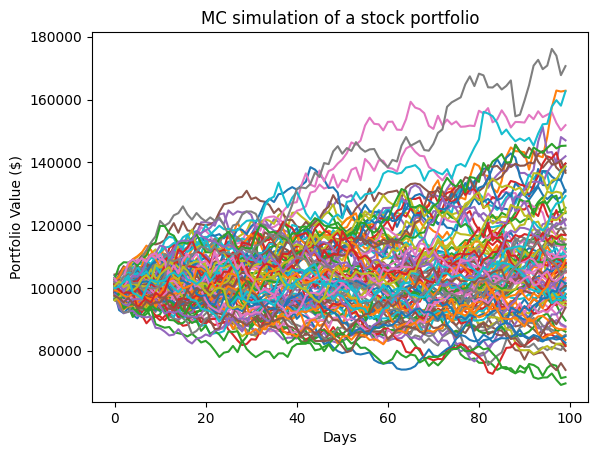

In [3]:
tickers = ['AAPL', 'TSLA']
list_weights = [50,50]
initial_investment = 100000

portfolio_1 = MonteCarloVaR(tickers, initial_investment, list_weights)